In [2]:
import os
import torch
import shutil
import joblib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from transformers import CLIPProcessor, CLIPModel
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, TensorDataset

# Feature extraction

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Importing the files from the drive for easy I/O in case connection breaks with drive

# Task 1 Datasheet
for i in range(1, 11):
    train_src = f"/content/drive/MyDrive/mukulsaini1214/part_one_dataset/train_data/{i}_train_data.tar.pth"
    eval_src = f"/content/drive/MyDrive/mukulsaini1214/part_one_dataset/eval_data/{i}_eval_data.tar.pth"
    shutil.copy(train_src, f"/tmp/{i}_train1.tar.pth")
    shutil.copy(eval_src, f"/tmp/{i}_eval1.tar.pth")

# Task 2 Datasheet
for i in range(1, 11):
    train_src = f"/content/drive/MyDrive/mukulsaini1214/part_two_dataset/train_data/{i}_train_data.tar.pth"
    eval_src = f"/content/drive/MyDrive/mukulsaini1214/part_two_dataset/eval_data/{i}_eval_data.tar.pth"
    shutil.copy(train_src, f"/tmp/{i}_train2.tar.pth")
    shutil.copy(eval_src, f"/tmp/{i}_eval2.tar.pth")

In [5]:
!pip install transformers torchvision ftfy --quiet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
def extract_and_save_features_clip(input_path, output_dir):
    base = os.path.basename(input_path).replace(".tar.pth", "")
    f_out = os.path.join(output_dir, f"{base}_features.npy")
    l_out = os.path.join(output_dir, f"{base}_labels.npy")

    # Load image data
    data = torch.load(input_path, map_location='cpu',weights_only=False)
    images = data['data']
    labels = data.get('targets', [0] * len(images))

    all_features = []
    batch_size = 32

    for i in range(0, len(images), batch_size):
        batch_imgs = [Image.fromarray(img.astype(np.uint8)) for img in images[i:i+batch_size]]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            features = clip_model.get_image_features(**inputs)
        features = features.cpu().numpy()
        all_features.append(features)

    all_features = np.concatenate(all_features, axis=0)
    labels = np.array(labels)

    np.save(f_out, all_features)
    np.save(l_out, labels)
    print(f"[SAVED] {f_out}, {l_out}")

# Saving the features for further use

In [7]:
# Task 1 Features
output_dir = "/content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features"
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 11):
    extract_and_save_features_clip(f"/tmp/{i}_train1.tar.pth", output_dir)
    extract_and_save_features_clip(f"/tmp/{i}_eval1.tar.pth", output_dir)

# Task 2 Features
output_dir = "/content/drive/MyDrive/mukulsaini1214/part_two_dataset/clip_features"
os.makedirs(output_dir, exist_ok=True)

for i in range(1, 11):
    extract_and_save_features_clip(f"/tmp/{i}_train2.tar.pth", output_dir)
    extract_and_save_features_clip(f"/tmp/{i}_eval2.tar.pth", output_dir)

[SAVED] /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/1_train1_features.npy, /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/1_train1_labels.npy
[SAVED] /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/1_eval1_features.npy, /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/1_eval1_labels.npy
[SAVED] /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/2_train1_features.npy, /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/2_train1_labels.npy
[SAVED] /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/2_eval1_features.npy, /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/2_eval1_labels.npy
[SAVED] /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/3_train1_features.npy, /content/drive/MyDrive/mukulsaini1214/part_one_dataset/clip_features/3_train1_labels.npy
[SAVED] /content/drive/MyDrive/mukulsaini1214/part_one_data

## Importing the files from the drive for easy I/O in case connection breaks with drive

In [8]:
# Task 1 Features
for i in range(1, 11):
    base_path = "/content/drive/MyDrive/mukulsaini1214/part_one_dataset"
    shutil.copy(f"{base_path}/clip_features/{i}_train1_features.npy", f"/tmp/{i}_train1_features.npy")
    shutil.copy(f"{base_path}/clip_features/{i}_train1_labels.npy", f"/tmp/{i}_train1_labels.npy")
    shutil.copy(f"{base_path}/clip_features/{i}_eval1_features.npy", f"/tmp/{i}_eval1_features.npy")
    shutil.copy(f"{base_path}/clip_features/{i}_eval1_labels.npy", f"/tmp/{i}_eval1_labels.npy")

# Task 2 Features
for i in range(1, 11):
    base_path = "/content/drive/MyDrive/mukulsaini1214/part_two_dataset"
    shutil.copy(f"{base_path}/clip_features/{i}_train2_features.npy", f"/tmp/{i+10}_train2_features.npy")
    shutil.copy(f"{base_path}/clip_features/{i}_train2_labels.npy", f"/tmp/{i+10}_train2_labels.npy")
    shutil.copy(f"{base_path}/clip_features/{i}_eval2_features.npy", f"/tmp/{i+10}_eval2_features.npy")
    shutil.copy(f"{base_path}/clip_features/{i}_eval2_labels.npy", f"/tmp/{i+10}_eval2_labels.npy")

### Because we have good amount of features extracted using CLIP. Now we will feature selection to keep only important features only .


### For this we will use **PCA**
### We will draw the graph between the no of no of features vs accuracy for the labeled dataset(1)
### We will be using the basic linear model **Logistic Regression** to reduce the no of parameters

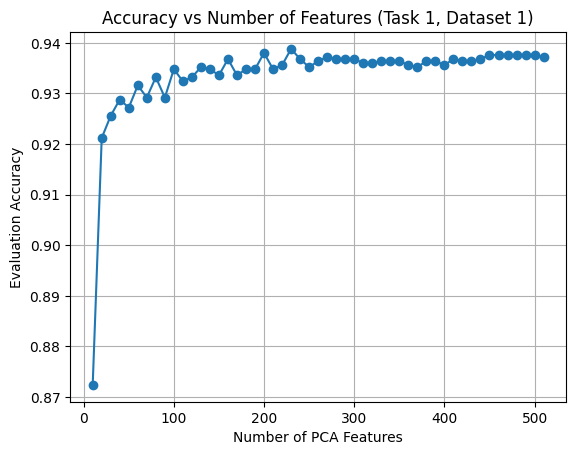

In [9]:
X_train = np.load("/tmp/1_train1_features.npy")
y_train = np.load("/tmp/1_train1_labels.npy")
X_eval = np.load("/tmp/1_eval1_features.npy")
y_eval = np.load("/tmp/1_eval1_labels.npy")

accuracies = []
components_list = list(range(10, min(X_train.shape[1], 512), 10))  # up to 512

for n in components_list:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_eval_pca = pca.transform(X_eval)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_pca, y_train)
    acc = accuracy_score(y_eval, clf.predict(X_eval_pca))
    accuracies.append(acc)
plt.plot(components_list, accuracies, marker='o')
plt.xlabel("Number of PCA Features")
plt.ylabel("Evaluation Accuracy")
plt.title("Accuracy vs Number of Features (Task 1, Dataset 1)")
plt.grid(True)
plt.show()


## PCA tuning is complete; final setup is ready

# **TASK 1**

In [10]:
# Load D1
i = 1
X_train = np.load(f"/tmp/{i}_train1_features.npy")
y_train = np.load(f"/tmp/{i}_train1_labels.npy")
X_eval = np.load(f"/tmp/{i}_eval1_features.npy")
y_eval = np.load(f"/tmp/{i}_eval1_labels.npy")

# PCA on D1
pca = PCA(n_components=512)
X_train_pca = pca.fit_transform(X_train)
X_eval_pca = pca.transform(X_eval)

# Train f1
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_pca, y_train)

# Save f1
model_dir = "/content/drive/MyDrive/mukulsaini1214/part_one_dataset/all_models"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(clf, os.path.join(model_dir, "model_f1.joblib"))
joblib.dump(pca, os.path.join(model_dir, "pca_256.joblib"))

# Self-training loop
all_models = [clf]
accuracy_matrix = np.zeros((10, 10))
accuracy_matrix[0, 0] = accuracy_score(y_eval, clf.predict(X_eval_pca))

for i in range(2, 11):
    print(f"\n--- Processing D{i} ---")
    prev_model = all_models[-1]

    # Load features for Di
    X_i = np.load(f"/tmp/{i}_train1_features.npy")
    X_i_pca = pca.transform(X_i)

    # Pseudo-label
    pseudo_labels = prev_model.predict(X_i_pca)

    # Train f{i}
    clf_i = LogisticRegression(max_iter=1000)
    clf_i.fit(X_i_pca, pseudo_labels)
    all_models.append(clf_i)
    joblib.dump(clf_i, os.path.join(model_dir, f"model_f{i}.joblib"))

    # Evaluate on D1 to D{i}
    for j in range(1, i + 1):
        X_eval = np.load(f"/tmp/{j}_eval1_features.npy")
        y_eval = np.load(f"/tmp/{j}_eval1_labels.npy")
        X_eval_pca = pca.transform(X_eval)
        acc = accuracy_score(y_eval, clf_i.predict(X_eval_pca))
        accuracy_matrix[i - 1, j - 1] = acc

# Save accuracy matrix
np.save(os.path.join(model_dir, "accuracy_matrix_task1.npy"), accuracy_matrix)


--- Processing D2 ---

--- Processing D3 ---

--- Processing D4 ---

--- Processing D5 ---

--- Processing D6 ---

--- Processing D7 ---

--- Processing D8 ---

--- Processing D9 ---

--- Processing D10 ---


## Printing the accuracy matrix for task 1



In [11]:
model_dir = "/content/drive/MyDrive/mukulsaini1214/part_one_dataset/all_models"
acc_matrix = np.load(os.path.join(model_dir, "accuracy_matrix_task1.npy"))

print("Accuracy Matrix (Task 1):\n")
for i in range(10):
    row_str = "Model f{:>2d}: ".format(i + 1)
    for j in range(10):
        row_str += "{:6.2f}  ".format(acc_matrix[i, j] * 100)
    print(row_str)

Accuracy Matrix (Task 1):

Model f 1:  93.72    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00  
Model f 2:  93.36   93.96    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00  
Model f 3:  93.00   93.08   92.96    0.00    0.00    0.00    0.00    0.00    0.00    0.00  
Model f 4:  92.60   92.64   92.64   92.76    0.00    0.00    0.00    0.00    0.00    0.00  
Model f 5:  92.44   92.76   92.16   92.28   92.84    0.00    0.00    0.00    0.00    0.00  
Model f 6:  92.08   92.32   92.28   92.40   92.88   92.56    0.00    0.00    0.00    0.00  
Model f 7:  92.36   92.68   91.88   92.96   92.52   93.04   92.20    0.00    0.00    0.00  
Model f 8:  91.72   92.60   92.08   92.44   92.68   92.92   92.32   91.60    0.00    0.00  
Model f 9:  91.88   92.24   92.00   92.24   92.12   93.08   91.92   91.64   92.40    0.00  
Model f10:  91.56   92.64   92.08   92.08   91.40   92.72   91.32   92.04   92.76   91.52  


# **ACCURACY FOR LABELLED D1: 93.72%**

# **AVG. ACCURACY: 92.01%**

# **TASK 2**

In [12]:
# Load f10 and PCA from Task 1
task1_model_dir = "/content/drive/MyDrive/mukulsaini1214/part_one_dataset/all_models"
clf = joblib.load(os.path.join(task1_model_dir, "model_f10.joblib"))
pca = joblib.load(os.path.join(task1_model_dir, "pca_256.joblib"))

# Directory to save Task 2 models
task2_model_dir = "/content/drive/MyDrive/mukulsaini1214/part_two_dataset/all_models"
os.makedirs(task2_model_dir, exist_ok=True)

all_models = [clf]  # f10 as starting point
accuracy_matrix = np.zeros((10, 20))  # 10 models × 20 held-out datasets

# Evaluate f10 on D1–D10
for j in range(1, 11):
    X_eval = np.load(f"/tmp/{j}_eval1_features.npy")
    y_eval = np.load(f"/tmp/{j}_eval1_labels.npy")
    X_eval_pca = pca.transform(X_eval)
    accuracy_matrix[0, j-1] = accuracy_score(y_eval, clf.predict(X_eval_pca))

# Train f11 to f20
for i in range(11, 21):
    print(f"\n--- Processing D{i} ---")
    prev_model = all_models[-1]

    # Load Di train features
    X_i = np.load(f"/tmp/{i}_train2_features.npy")
    X_i_pca = pca.transform(X_i)

    # Generate pseudo-labels using previous model
    probs = prev_model.predict_proba(X_i_pca)
    confidences = np.max(probs, axis=1)
    pseudo_labels = np.argmax(probs, axis=1)

    # Keep only high-confidence pseudo-labels
    threshold = 0.8
    mask = confidences >= threshold
    X_filtered = X_i_pca[mask]
    pseudo_labels_filtered = pseudo_labels[mask]

    print(f"  Using {len(X_filtered)} / {len(X_i_pca)} samples (confidence ≥ {threshold})")

    # Train f{i}
    clf_i = LogisticRegression(max_iter=1000)
    clf_i.fit(X_filtered, pseudo_labels_filtered)
    all_models.append(clf_i)
    joblib.dump(clf_i, os.path.join(task2_model_dir, f"model_f{i}.joblib"))

    # Evaluate f{i} on D1 to D{i}
    for j in range(1, i + 1):
        if j <= 10:
            X_eval = np.load(f"/tmp/{j}_eval1_features.npy")
            y_eval = np.load(f"/tmp/{j}_eval1_labels.npy")
        else:
            X_eval = np.load(f"/tmp/{j}_eval2_features.npy")
            y_eval = np.load(f"/tmp/{j}_eval2_labels.npy")

        X_eval_pca = pca.transform(X_eval)
        acc = accuracy_score(y_eval, clf_i.predict(X_eval_pca))
        accuracy_matrix[i - 11, j - 1] = acc

# Save Task 2 accuracy matrix
np.save(os.path.join(task2_model_dir, "accuracy_matrix_task2.npy"), accuracy_matrix)


--- Processing D11 ---
  Using 1972 / 2500 samples (confidence ≥ 0.8)

--- Processing D12 ---
  Using 1442 / 2500 samples (confidence ≥ 0.8)

--- Processing D13 ---
  Using 2043 / 2500 samples (confidence ≥ 0.8)

--- Processing D14 ---
  Using 2218 / 2500 samples (confidence ≥ 0.8)

--- Processing D15 ---
  Using 2240 / 2500 samples (confidence ≥ 0.8)

--- Processing D16 ---
  Using 2020 / 2500 samples (confidence ≥ 0.8)

--- Processing D17 ---
  Using 2192 / 2500 samples (confidence ≥ 0.8)

--- Processing D18 ---
  Using 2065 / 2500 samples (confidence ≥ 0.8)

--- Processing D19 ---
  Using 1774 / 2500 samples (confidence ≥ 0.8)

--- Processing D20 ---
  Using 2120 / 2500 samples (confidence ≥ 0.8)


## Accuracy matrix for task 2

In [13]:
task2_model_dir = "/content/drive/MyDrive/mukulsaini1214/part_two_dataset/all_models"
acc_matrix = np.load(os.path.join(task2_model_dir, "accuracy_matrix_task2.npy"))

print("Accuracy Matrix (Task 2):\n")
for i in range(10):
    row_str = f"Model f{10 + i + 1:>2d}: "
    for j in range(20):
        row_str += "{:6.2f}  ".format(acc_matrix[i, j] * 100)
    print(row_str)

Accuracy Matrix (Task 2):

Model f11:  91.84   92.12   91.88   91.72   91.80   91.92   90.84   91.48   91.72   91.28   79.88    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00  
Model f12:  89.44   90.80   90.52   90.04   90.08   90.68   89.64   89.92   89.92   89.76   77.32   52.48    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00  
Model f13:  89.24   90.60   90.28   89.88   90.28   90.32   89.40   89.44   89.48   89.60   76.04   50.72   76.64    0.00    0.00    0.00    0.00    0.00    0.00    0.00  
Model f14:  88.68   89.76   89.64   89.52   89.72   89.68   89.28   88.92   88.80   88.84   75.92   48.92   75.44   83.36    0.00    0.00    0.00    0.00    0.00    0.00  
Model f15:  88.40   89.88   89.04   89.20   89.68   89.48   89.32   88.88   88.88   89.00   75.24   48.28   75.40   82.72   87.28    0.00    0.00    0.00    0.00    0.00  
Model f16:  87.84   88.92   88.92   88.80   89.28   88.68   88.44   87.76   88.44   88.44   74.20   48.00   74.60

# **AVG. ACCURACY: 78.45%**